# 6.4: Resampling Exercises

## Getting Started

### Import Libraries 

We import our standard libraries and specific objects/libraries at the top level of our notebook.

In [2]:
# Load our previous libraries and objects
import numpy as np
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
                         summarize,
                         poly)
from sklearn.model_selection import train_test_split

# Import new libraries and objects
from functools import partial
from sklearn.base import clone
from ISLP.models import sklearn_sm

In [3]:
Auto = load_data('Auto')
Auto_train, Auto_valid = train_test_split(Auto,
                                         test_size=196, # split in two
                                         random_state=0) # random seed

## The Bootstrap

The bootstrap approach can be applied in almost all situations. While there are several implementations of the bootstrap in Python, its use for estimating standard error is simple enough that we write our own function below for the case when our data is stored in a dataframe. We will use the `Portfolio` data set in the `ISLP` package to illustrate.

We will create a function `alpha_func()`, which takes as input a dataframe `D` assumed
to have columns `X` and `Y`, as well as a
vector `idx` indicating which observations should be used to
estimate 
$\alpha$. The function then outputs the estimate for $\alpha$ based on
the selected observations.

In [8]:
Portfolio = load_data('Portfolio')
def alpha_func(D, idx):
   cov_ = np.cov(D[['X','Y']].loc[idx], rowvar=False)
   return ((cov_[1,1] - cov_[0,1]) /
           (cov_[0,0]+cov_[1,1]-2*cov_[0,1]))

In [16]:
import matplotlib.pyplot as plt


(array([ 4.,  4.,  8., 17., 22., 11., 14., 14.,  3.,  3.]),
 array([-2.72528149, -2.19615482, -1.66702814, -1.13790146, -0.60877478,
        -0.0796481 ,  0.44947857,  0.97860525,  1.50773193,  2.03685861,
         2.56598529]),
 <BarContainer object of 10 artists>)

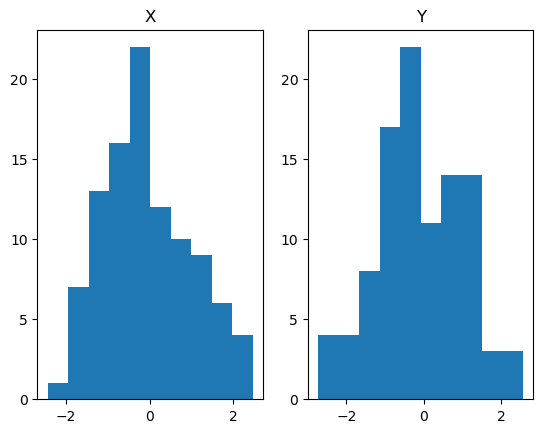

In [23]:
plt.subplot(1,2,1)
plt.title("X")
plt.hist(Portfolio['X'])
plt.subplot(1,2,2)
plt.title("Y")
plt.hist(Portfolio['Y'])

The following command estimates $\alpha$ using all 100 observations.

In [ ]:
alpha_func(Portfolio, range(100))

Next we randomly select 100 observations from range(100), with replacement. This is equivalent to constructing a new bootstrap data set and recomputing $\alpha$ based on the new data set.

In [ ]:
rng = np.random.default_rng(0)
alpha_func(Portfolio,
           rng.choice(100,
                      100,
                      replace=True))

This process can be generalized to create a simple function `boot_SE()` for computing the bootstrap standard error for arbitrary functions that take only a data frame as an argument.

In [ ]:
import warnings



def boot_SE(func,
            D,
            n=None,
            B=1000,
            seed=0):
    # NOTE: Suppress FutureWarning in ISLP.models.columns
    # The warning is related to Series.__getitem__ treating keys as positions, which is deprecated.
    # Since ISLP is an external library that I don't control, and this specific warning does not
    # affect my current usage, I'm suppressing it to keep the output clean and focused on relevant information.
    warnings.filterwarnings(action='ignore', category=FutureWarning, module='ISLP.models.columns', lineno=151)
    
    rng = np.random.default_rng(seed)
    first_, second_ = 0, 0
    n = n or D.shape[0]
    for _ in range(B):
        idx = rng.choice(D.index,
                         n,
                         replace=True)
        value = func(D, idx)
        first_ += value
        second_ += value**2
    return np.sqrt(second_ / B - (first_ / B)**2)

Let’s use our function to evaluate the accuracy of our estimate of $\alpha$ using $B = 1,000$ bootstrap replications.

In [ ]:
alpha_SE = boot_SE(alpha_func,
                   Portfolio,
                   B=1000,
                   seed=0)
alpha_SE

The final output shows that the bootstrap estimate for ${\rm SE}(\hat{\alpha})$ is $0.0912$.

The bootstrap approach can be used to assess the variability of the coefficient estimates and predictions from a statistical learning method. Here we use the bootstrap approach in order to assess the variability of the estimates for 
 and 
, the intercept and slope terms for the linear regression model that uses horsepower to predict mpg in the Auto data set

We start by writing a generic function `boot_OLS()` for bootstrapping a regression model that takes a formula to define the corresponding regression. We use the `clone()` function to make a copy of the formula that can be refit to the new dataframe. This means that any derived features such as those defined by `poly()` which will be re-fit on the resampled data frame.

In [ ]:
def boot_OLS(model_matrix, response, D, idx):
    D_ = D.loc[idx]
    Y_ = D_[response]
    X_ = clone(model_matrix).fit_transform(D_)
    return sm.OLS(Y_, X_).fit().params

hp_func = partial(boot_OLS, MS(['horsepower']), 'mpg')

# Use the hp_func() function to create bootstrap estimates for the intercept and slope 
rng = np.random.default_rng(0)
np.array([hp_func(Auto,
          rng.choice(392,
                     392,
                     replace=True)) for _ in range(10)])

Next, we use the `boot_SE()` {} function to compute the standard errors of 1,000 bootstrap estimates for the intercept and slope terms.

In [ ]:
hp_se = boot_SE(hp_func,
                Auto,
                B=1000,
                seed=10)
hp_se

The bootstrap estimate for ${\rm SE}(\hat{\beta}_0)$ is
0.85, and that the bootstrap
estimate for ${\rm SE}(\hat{\beta}_1)$ is
0.0074. Standard formulas can be used to compute the standard errors for the regression coefficients in a linear model. These can be obtained using the `summarize()` function from `ISLP.sm`.

In [ ]:
hp_model = sklearn_sm(sm.OLS,
                      MS(['horsepower']))

hp_model.fit(Auto, Auto['mpg'])
model_se = summarize(hp_model.results_)['std err']
model_se

The standard error estimates for $\hat{\beta}_0$ and $\hat{\beta}_1$ are 0.717 for the intercept and 0.006 for the slope.

Now, we want to compute the boostrap:

In [ ]:
quad_model = MS([poly('horsepower', 2, raw=True)])
quad_func = partial(boot_OLS,
                    quad_model,
                    'mpg')
boot_SE(quad_func, Auto, B=1000)

We compare the results to the standard errors computed using `sm.OLS()`.

In [ ]:
M = sm.OLS(Auto['mpg'],
           quad_model.fit_transform(Auto))
summarize(M.fit())['std err']

*These exercises were adapted from :* James, Gareth, et al. An Introduction to Statistical Learning: with Applications in Python, Springer, 2023.